## Scoring customer propensity to purchase
Đào tạo mô hình dựa trên hành động của người mua hàng trên trang web để xác định những khách hàng tiềm năng tốt nhất đã không mua hàng ngày hôm qua.

**Notes**; I am a beginner at machine learning and I've written this kernal to share what I am learning with others, please feel free to share feedback and advice as this will help me and others reading this kernal. This data is sampled and all UserIDs are dummies.

### Introduction
Chúng tôi có nhiều khách truy cập vào trang web của chúng tôi mỗi ngày, một số mua hàng nhưng nhiều người thì không. Chúng tôi chi tiền để nhắm mục tiêu lại những khách truy cập trong quá khứ, chúng tôi muốn tối ưu hóa hoạt động này bằng cách nhắm mục tiêu đến những khách truy cập có nhiều khả năng chuyển đổi hơn. Để làm điều này, chúng tôi đã lấy dữ liệu hiển thị những phần nào của trang web mà người dùng đã tương tác, câu hỏi của chúng tôi là:

1. Tương tác nào sau đây ảnh hưởng đến khả năng mua hàng của người dùng?
2. Chúng ta có thể chấm điểm những khách truy cập hôm qua chưa mua hàng để xem ai là khách hàng tiềm năng có giá trị nhất không?

![](https://image.ibb.co/ecGtqy/stats_2.png)

In [117]:
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
from sklearn.model_selection  import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics

Trước tiên, hãy tải tệp dữ liệu huấn luyện vào và xem nó...

In [118]:
train = pd.read_csv('training_sample.csv')

train.dtypes

UserID                     object
basket_icon_click           int64
basket_add_list             int64
basket_add_detail           int64
sort_by                     int64
image_picker                int64
account_page_click          int64
promo_banner_click          int64
detail_wishlist_add         int64
list_size_dropdown          int64
closed_minibasket_click     int64
checked_delivery_detail     int64
checked_returns_detail      int64
sign_in                     int64
saw_checkout                int64
saw_sizecharts              int64
saw_delivery                int64
saw_account_upgrade         int64
saw_homepage                int64
device_mobile               int64
device_computer             int64
device_tablet               int64
returning_user              int64
loc_uk                      int64
ordered                     int64
dtype: object

Được rồi, chúng ta có một loạt các cột số nguyên, mỗi cột phản ánh một hành động trên trang web và một cột đối tượng, trông giống như mã định danh người dùng. Hãy cùng xem thêm một số phương pháp...

In [119]:
print(train.describe())

print(train.info())

       basket_icon_click  basket_add_list  basket_add_detail        sort_by  \
count      455401.000000    455401.000000      455401.000000  455401.000000   
mean            0.099150         0.074521           0.112916       0.036849   
std             0.298864         0.262617           0.316490       0.188391   
min             0.000000         0.000000           0.000000       0.000000   
25%             0.000000         0.000000           0.000000       0.000000   
50%             0.000000         0.000000           0.000000       0.000000   
75%             0.000000         0.000000           0.000000       0.000000   
max             1.000000         1.000000           1.000000       1.000000   

        image_picker  account_page_click  promo_banner_click  \
count  455401.000000       455401.000000       455401.000000   
mean        0.026735            0.003570            0.016208   
std         0.161307            0.059647            0.126274   
min         0.000000            

So it looks like this data is just below half a million rows, with a total of 25 columns. Let's take a look at some of the data using HEAD...

In [120]:
train.head(3)

,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,...,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered
0,a720-6b732349-a720-4862-bd21-644732,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,a0c0-6b73247c-a0c0-4bd9-8baa-797356,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,86a8-6b735c67-86a8-407b-ba24-333055,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0



### Is there any correlation
Để trả lời câu hỏi đầu tiên của chúng tôi, chúng tôi có thể bắt đầu bằng cách khám phá bất kỳ mối tương quan nào giữa các hành động trên trang web riêng lẻ và đơn đặt hàng, vì chúng tôi có tất cả các trường này trong dữ liệu của mình.


Chúng tôi có khá nhiều trường, vì vậy hãy bắt đầu với bản đồ nhiệt để xem mối tương quan...

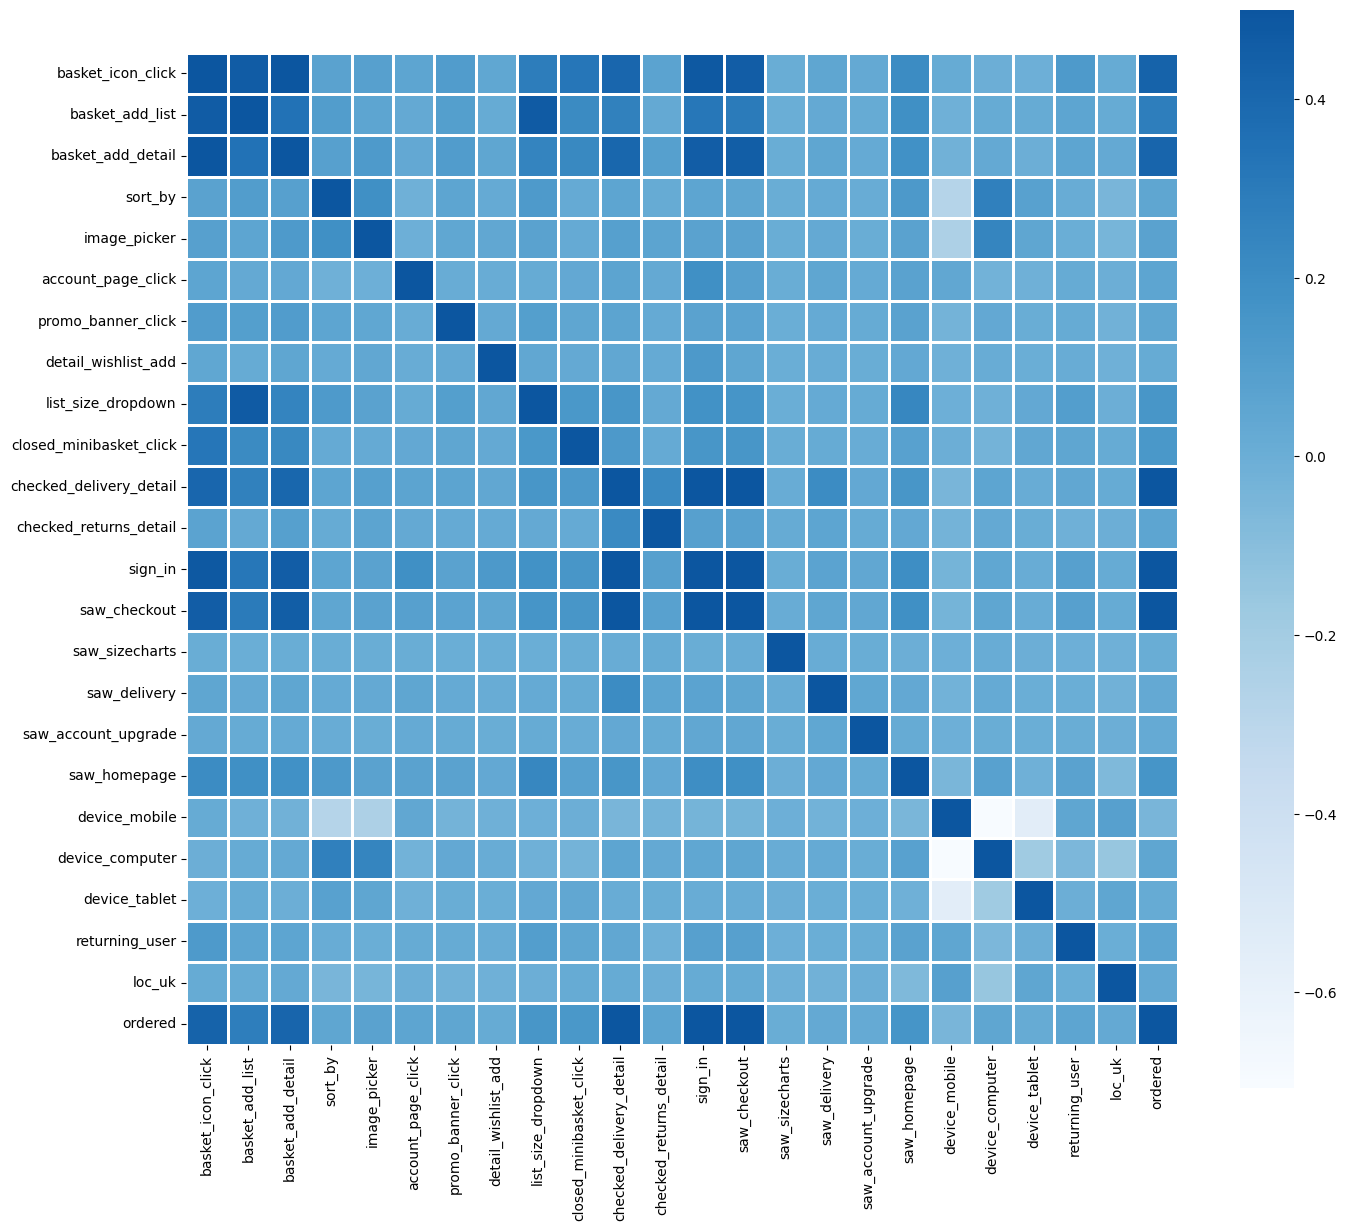

In [121]:
import seaborn as sns
corr = train.iloc[:, 1:].corr()
plt.figure(figsize=(16, 14))
sns.heatmap(corr, vmax=0.5, center=0,
            square=True, linewidths=2, cmap='Blues') 
plt.show()

Interesting - there seems to be a strong correlation between visitors who ordered and visitors who saw the checkout, this makes sense! There are also strong correlations for people who cheked out delivery times and added items to their shopping cart - let's get a closer look at the correlations for orders...

Được rồi! Có vẻ như thông tin chi tiết ban đầu của chúng tôi về bản đồ nhiệt là chính xác, người dùng đã xem các tùy chọn giao hàng trên trang chi tiết sản phẩm có mối tương quan gần như 80% với đơn đặt hàng, chắc chắn có thứ gì đó ở đây chúng tôi có thể sử dụng! Nhưng chờ đã...có vẻ như không có nhiều mối tương quan giữa người dùng trên thiết bị di động và đơn đặt hàng, vì vậy chúng ta có thể nên xóa trường này khỏi công cụ dự đoán của mình.

### Let's get predicting!

Trước tiên, chúng tôi xây dựng các biến dự đoán và biến mục tiêu, chúng tôi sẽ loại bỏ các biến dự đoán 'có thứ tự', vì đây là biến mục tiêu của chúng tôi. Chúng tôi cũng sẽ xóa 'UserID' vì nó không ảnh hưởng đến khả năng đặt hàng và 'device_mobile' vì chúng tôi thấy nó có mối tương quan nghịch với các đơn đặt hàng.

In [122]:
# Drop columns with low correlation
predictors = train.drop(['ordered','UserID','device_mobile'], axis=1)
# predictors = train[['checked_delivery_pdp', 'basket_icon_click', 'sign_in', 'saw_checkout']]
targets = train.ordered

In [123]:
print(predictors.columns)

Index(['basket_icon_click', 'basket_add_list', 'basket_add_detail', 'sort_by',
       'image_picker', 'account_page_click', 'promo_banner_click',
       'detail_wishlist_add', 'list_size_dropdown', 'closed_minibasket_click',
       'checked_delivery_detail', 'checked_returns_detail', 'sign_in',
       'saw_checkout', 'saw_sizecharts', 'saw_delivery', 'saw_account_upgrade',
       'saw_homepage', 'device_computer', 'device_tablet', 'returning_user',
       'loc_uk'],
      dtype='object')


In [124]:
X_train, X_test, y_train, y_test  =   train_test_split(predictors, targets, test_size=.3)

print( "Predictor - Training : ", X_train.shape, "Predictor - Testing : ", X_test.shape )

Predictor - Training :  (318780, 22) Predictor - Testing :  (136621, 22)


In [125]:
from sklearn.naive_bayes import GaussianNB

classifier=GaussianNB()
classifier=classifier.fit(X_train,y_train)

predictions=classifier.predict(X_test)

#Analyze accuracy of predictions
sklearn.metrics.confusion_matrix(y_test,predictions)

array([[129357,   1551],
       [    72,   5641]], dtype=int64)

In [126]:
sklearn.metrics.accuracy_score(y_test, predictions)

0.9881204207259499

### Now to predict on the previous days visitors!
Start by loading in our sample data of the **previous days visitors who did not order**.

In [141]:
yesterday_prospects = pd.read_csv('testing_sample.csv')

Now let's explore this DataFrame and check everything is as expected...

In [142]:
print(yesterday_prospects.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151655 entries, 0 to 151654
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   UserID                   151655 non-null  object
 1   basket_icon_click        151655 non-null  int64 
 2   basket_add_list          151655 non-null  int64 
 3   basket_add_detail        151655 non-null  int64 
 4   sort_by                  151655 non-null  int64 
 5   image_picker             151655 non-null  int64 
 6   account_page_click       151655 non-null  int64 
 7   promo_banner_click       151655 non-null  int64 
 8   detail_wishlist_add      151655 non-null  int64 
 9   list_size_dropdown       151655 non-null  int64 
 10  closed_minibasket_click  151655 non-null  int64 
 11  checked_delivery_detail  151655 non-null  int64 
 12  checked_returns_detail   151655 non-null  int64 
 13  sign_in                  151655 non-null  int64 
 14  saw_checkout        

In [143]:
userids = yesterday_prospects['UserID']

yesterday_prospects = yesterday_prospects.drop(['ordered','UserID','device_mobile'], axis=1)

yesterday_prospects.head(3)

,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,...,sign_in,saw_checkout,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_computer,device_tablet,returning_user,loc_uk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [130]:
yesterday_prospects.shape

(151655, 22)

In [145]:
yesterday_prospects['propensity'] = classifier.predict_proba(yesterday_prospects)[:,1]

yesterday_prospects.head(3)

,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,...,saw_checkout,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_computer,device_tablet,returning_user,loc_uk,propensity
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.0


Có vẻ tốt! Bây giờ chúng tôi muốn đưa UserID trở lại để chúng tôi có thể xác định những người dùng này trong tương lai (lưu ý, đây là những ID giả).

In [146]:
yesterday_prospects.sort_values(by='propensity', ascending=False).head(100)

,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,...,saw_checkout,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_computer,device_tablet,returning_user,loc_uk,propensity
22326,1,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,1.0
13372,1,0,1,0,0,0,0,0,1,0,...,1,0,0,0,1,0,1,1,1,1.0
13669,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,1,1,1.0
138601,1,0,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,1,1,1.0
13626,0,0,1,0,1,0,0,0,1,0,...,1,0,0,0,1,1,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28825,1,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,1,1.0
102768,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,1,1,1.0
139016,1,1,1,1,0,0,0,0,1,0,...,1,0,0,0,1,1,0,1,1,1.0
28905,1,1,1,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,1,1,1.0


In [147]:
results = pd.concat([userids, yesterday_prospects], axis=1)

All done - let's take a look at our results data frame:

In [149]:
results.to_csv('results.csv')

In [150]:
import uuid

print(uuid.uuid4())

7a1e8284-d06f-4ef4-b63d-a8bf7bf0d1da


In [151]:
import pickle

# Giả sử 'model' là model của bạn
# Lưu model vào file
with open('model_filename.pkl', 'wb') as file:
    pickle.dump(classifier, file)



In [152]:
with open('model_filename.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [153]:
len(yesterday_prospects.drop('propensity', axis=1).columns)

22

In [154]:
a = loaded_model.predict_proba(yesterday_prospects.drop('propensity', axis=1))[:,1]
a

array([0., 0., 0., ..., 0., 0., 0.])

In [155]:
b = pd.DataFrame(a, columns=['propensity'])

In [159]:
b.max()

propensity    1.0
dtype: float64